In [1]:
!gdown --id 1TOAeQXjxtsTwQGH6-pbHPLchtm-mS-QI
!gdown --id 1BQvwhSoeDm-caCImtlbcAMzhI8MDsrCZ

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TOAeQXjxtsTwQGH6-pbHPLchtm-mS-QI
From (redirected): https://drive.google.com/uc?id=1TOAeQXjxtsTwQGH6-pbHPLchtm-mS-QI&confirm=t&uuid=8a7539ca-6777-4433-91ae-b60cd5b5fa68
To: /content/data.zip
100% 558M/558M [00:10<00:00, 51.5MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1BQvwhSoeDm-caCImtlbcAMzhI8MDsrCZ
From (redirected): https://drive.google.com/uc?id=1BQvwhSoeDm-caCImtlbcAMzhI8MDsrCZ&confirm=t&uuid=20352f39-6263-43a2-bd26-a3659a789452
To: /content/public test.zip
10

In [2]:
!unzip -q "data.zip"
!unzip -q "public test.zip"

# Classification daytime and nighttime

In [3]:
!pip install torchinfo --quiet

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from torchvision import transforms
from pathlib import Path
import os
from torch.utils.data import DataLoader
from torchinfo import summary

In [5]:
class DayNightClassifier(torch.nn.Module):
    def __init__(self, input_shape, hidden_unit, output_shape):
        super().__init__()
        self.classifier = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_unit),
            nn.ReLU(),
            nn.Linear(hidden_unit, output_shape)  # 2 classes: day/night
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [6]:
def get_file_path(folder):
    data = []
    sub_folders = list(sorted(os.listdir(folder)))
    sub_folder_paths = [os.path.join(folder, sub_folder) for sub_folder in sub_folders]
    # Kiểm tra tập train hay test
    try:
        contents = os.listdir(sub_folder_paths[0])
        if contents:
            # Duyêt qua tập daytime và nighttime
            for sub_folder_path in sub_folder_paths:
                data_paths = list(sorted(os.listdir(sub_folder_path)))
                data_path_file = [os.path.join(sub_folder_path, data_path) for data_path in data_paths]
                data.extend(data_path_file)

            return {'folder': 'train', 'file_train': data}
    except NotADirectoryError:
        return {'folder': 'test', 'file_test': sub_folder_paths}

class TrafficVehicle(Dataset):
    def __init__(self, folder: str, transforms=None):
        """
            transform_box sẽ chuyển tọa độ bounding box sang để phù hợp với các model, có hai kiểu để chuyển đổi
            là "center" hoặc "corner", mặc định là "center". Nếu transform_type="center" thì mặc định các model sử dụng bounding box
            theo tọa độ tâm và kích thước. Ngược lại, transform_type="corner" các model sẽ sử dụng bounding box theo tọa độ góc.

            Ví dụ: trong bài toán object detection các tọa độ bounding box thường chia thành hai kiểu:
                - (x_min, y_min, x_max, y_max)
                - (x_center, y_center, width, height)

            Lưu ý: Do trong quá trình gán nhãn theo định dạng YOLO (x_center, y_center, width, height) nên không cần transform_box nữa.
        """
        self.data = get_file_path(folder)
        self.transforms = transforms

        if self.data['folder'] == 'train':
            self.image, self.txt = [], []
            for train_path in self.data['file_train']:
                train_path_split = train_path.split('.')
                # Kiểm tra là txt hay là image
                if train_path_split[-1] == 'txt':
                    self.txt.append(train_path)
                else:
                    self.image.append(train_path)
        else:
            self.image = [image_path for image_path in self.data['file_test']]
        self.class_name = {0: "daytime", 1: "nighttime"}
        self.class_to_idx = {"daytime": 0, "nighttime": 1}
    def load_image(self, index):
        img = Image.open(self.image[index])
        return img
    def __len__(self):
        return len(self.image)
    def __getitem__(self, index: int):
        img = self.load_image(index)
        file_path = os.path.basename(self.image[index])
        if self.data['folder'] == 'train':
            label = Path(self.image[index]).parent.name
            if self.transforms is not None:
              return self.transforms(img), self.class_to_idx[label]
        else:
            if self.transforms is not None:
                img = self.transforms(img)
            return img, file_path

In [7]:
transform = transforms.Compose([
    transforms.Resize(size=(300, 300)),
    transforms.ToTensor()
])
train_data = TrafficVehicle("data/train", transforms=transform)
val_data = TrafficVehicle("data/val", transforms=transform)
test_data = TrafficVehicle("public test", transforms=transform)

In [8]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

## Neural Network

In [9]:
print(f"Shape of input: {train_data[0][0].shape}")

Shape of input: torch.Size([3, 300, 300])


In [10]:
flatten = nn.Flatten()
print(f"Shape of input after flatting: {flatten(train_data[0][0].unsqueeze(0)).shape}")

Shape of input after flatting: torch.Size([1, 270000])


In [11]:
model_1 = DayNightClassifier(input_shape=270000,
                             hidden_unit=8,
                             output_shape=1)
print(summary(model_1, input_size=[1, 3, 300, 300], col_names=['num_params', 'input_size' ,'trainable']))

Layer (type:depth-idx)                   Param #                   Input Shape               Trainable
DayNightClassifier                       --                        [1, 3, 300, 300]          True
├─Sequential: 1-1                        --                        [1, 3, 300, 300]          True
│    └─Flatten: 2-1                      --                        [1, 3, 300, 300]          --
│    └─Linear: 2-2                       2,160,008                 [1, 270000]               True
│    └─ReLU: 2-3                         --                        [1, 8]                    --
│    └─Linear: 2-4                       9                         [1, 8]                    True
Total params: 2,160,017
Trainable params: 2,160,017
Non-trainable params: 0
Total mult-adds (M): 2.16
Input size (MB): 1.08
Forward/backward pass size (MB): 0.00
Params size (MB): 8.64
Estimated Total Size (MB): 9.72


In [12]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
y_logits = model_1(train_data[0][0].to(device).unsqueeze(0))
y_pred = torch.sigmoid(y_logits)
print(y_pred)
y_pred = torch.round(y_pred)
print(y_pred)

tensor([[0.4906]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)


In [14]:
def accuracy_fn(y_true, y_pred):
  equal = torch.eq(y_true, y_pred)
  acc = equal.sum().item()
  return acc / len(y_true)

In [16]:
from tqdm.auto import tqdm
def train_step(train_dataloader, loss_fn, optimizer, model_1, device):
  model_1.train()
  model_1 = model_1.to(device)
  train_loss = 0
  train_acc = 0
  for X_train, y_train in tqdm(train_dataloader, total=len(train_dataloader)):
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train.float())
    train_loss += loss
    acc = accuracy_fn(y_train, y_pred)
    train_acc += acc

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  return train_loss, train_acc

def val_step(val_dataloader, loss_fn, model_1, device):
  model_1.eval()
  model_1 = model_1.to(device)
  val_loss = 0
  val_acc = 0
  with torch.inference_mode():
    for X_val, y_val in val_dataloader:
      X_val, y_val = X_val.to(device), y_val.to(device)
      y_logits = model_1(X_val).squeeze()
      y_pred = torch.round(torch.sigmoid(y_logits))

      loss = loss_fn(y_logits, y_val.float())
      val_loss += loss
      acc = accuracy_fn(y_val, y_pred)
      val_acc += acc

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    return val_loss, val_acc

In [17]:
torch.manual_seed(42)
epochs = 5
results = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
for epoch in range(epochs):
  print(f"Epoch {epoch + 1}/{epochs}")
  train_loss, train_acc = train_step(train_dataloader, loss_fn, optimizer, model_1, device)
  val_loss, val_acc = val_step(val_dataloader, loss_fn, model_1, device)

  print(f"Train loss: {train_loss:.4f} Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f} Val acc: {val_acc:.4f}")
  results["epoch"].append(epoch + 1)
  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc)
  results["val_loss"].append(val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss)
  results["val_acc"].append(val_acc)

Epoch 1/5


  0%|          | 0/296 [00:00<?, ?it/s]

Train loss: 0.2618 Train acc: 0.9719 | Val loss: 0.1614 Val acc: 1.0000
Epoch 2/5


  0%|          | 0/296 [00:00<?, ?it/s]

Train loss: 0.1649 Train acc: 0.9998 | Val loss: 0.1135 Val acc: 1.0000
Epoch 3/5


  0%|          | 0/296 [00:00<?, ?it/s]

Train loss: 0.1218 Train acc: 1.0000 | Val loss: 0.0868 Val acc: 1.0000
Epoch 4/5


  0%|          | 0/296 [00:00<?, ?it/s]

Train loss: 0.0952 Train acc: 1.0000 | Val loss: 0.0687 Val acc: 1.0000
Epoch 5/5


  0%|          | 0/296 [00:00<?, ?it/s]

Train loss: 0.0775 Train acc: 1.0000 | Val loss: 0.0567 Val acc: 1.0000


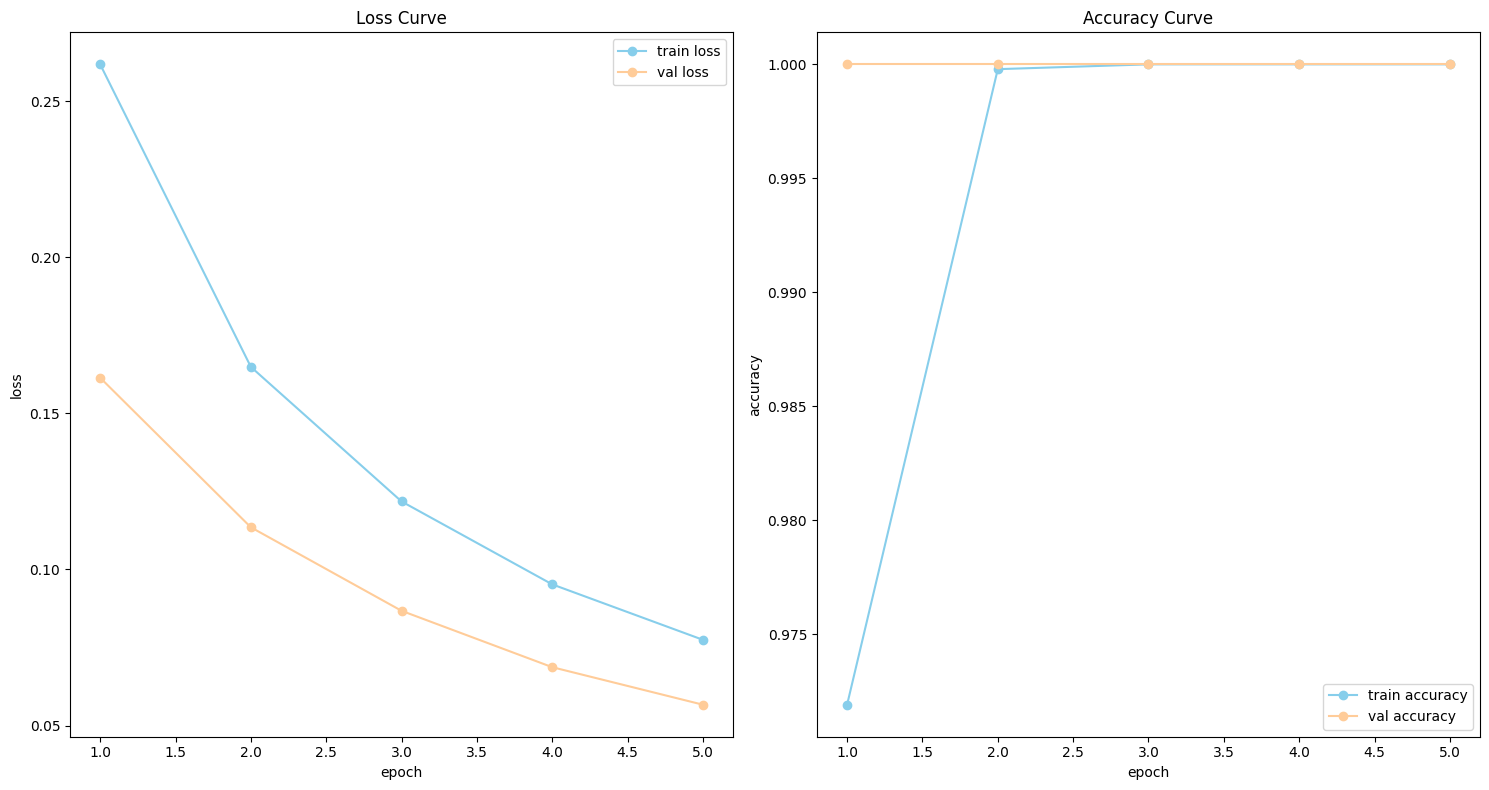

In [18]:
import matplotlib.pyplot as plt
epoch = np.array(results["epoch"])
train_loss = np.array(results["train_loss"]).ravel()
val_loss = np.array(results["val_loss"]).ravel()
train_acc = np.array(results["train_acc"])
val_acc = np.array(results["val_acc"])

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].plot(epoch, train_loss, color='#87CEEB', marker='o', label="train loss")
axes[0].plot(epoch, val_loss, color="#FFCC99", marker='o', label='val loss')
axes[0].set_title("Loss Curve")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].legend()

axes[1].plot(epoch, train_acc, color='#87CEEB', marker='o', label="train accuracy")
axes[1].plot(epoch, val_acc, color="#FFCC99", marker='o', label='val accuracy')
axes[1].set_title("Accuracy Curve")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")
axes[1].legend()

plt.tight_layout()
plt.savefig("results.png")
plt.show()

In [19]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model_classification.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

# Load model

In [6]:
class DayNightClassifier(torch.nn.Module):
    def __init__(self, input_shape, hidden_unit, output_shape):
        super().__init__()
        self.classifier = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_unit),
            nn.ReLU(),
            nn.Linear(hidden_unit, output_shape)  # 2 classes: day/night
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [21]:
import torch
from torch import nn
model = DayNightClassifier(input_shape=270000,
                            hidden_unit=8,
                             output_shape=1)
model.load_state_dict(torch.load("models/model_classification.pth", weights_only=True))

<All keys matched successfully>

# Testing

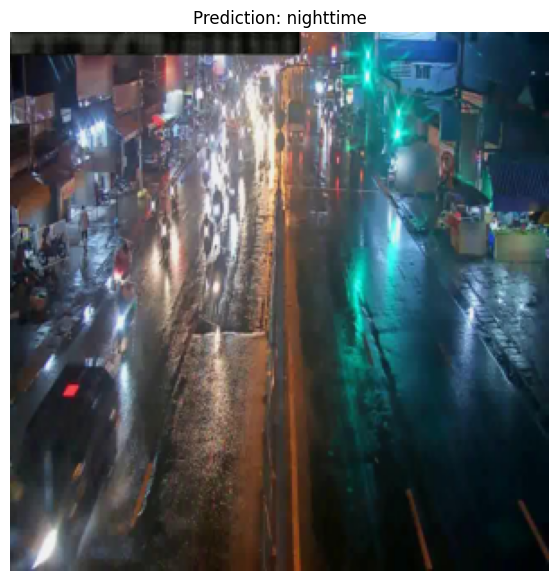

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
with torch.inference_mode():
  y_pred = model(test_data[0][0].to(device).unsqueeze(0))[0]

plt.figure(figsize=(10, 7))
plt.imshow(test_data[0][0].permute(1, 2, 0).cpu().detach().numpy())
plt.title(f"Prediction: {test_data.class_name[torch.round(torch.sigmoid(y_pred)).item()]}")
plt.axis("off")
plt.show()